## 1 . SSPP

Sloan Extension for Galactic Exploration and Understanding ([SEGUE](http://www.sdss3.org/surveys/segue2.php)) is a project that provides more than 230,000 stellar spectra. The raw spectra data is complex, it comprises information about the distance, redshift, and the chemical compositionof the observed object.  SEGUE Stellar Parameter Pipeline ([SSPP](https://iopscience.iop.org/article/10.1088/0004-6256/136/5/2022)) has produced a catalog of stellar objects. The pipeline has three major parameters, effective temperature ($T_{eff}$),surface gravity ($log\,g$), and metallicity (\[Fe/H\]). 

The presented analysis uses two parameters to describe the stellar populations: 

 - \[Fe/H\], or metallicity, refers to the proportion of elements that are not hydrogen or helium.
 
 - \[$\alpha/$Fe\] is the proportion of 'metallic' elements produced by the $\alpha$-ladder. $\alpha$-ladder is a fusion process that converts Helium into heavier elements. It usually produces elements with a multiple number of 4 neutrons+protons, some examples of elements are: Neon (Ne), Magnesium (Mg), Silicon (Si), Sulfur (S), Argon (Ar), Calcium (Ca) and Titanium (Ti).
  
<figure>
	<img src="fig/metal.png">
</figure>



### 1.1 KMeans

The method applied in this example is the KMeans, an unspuppervised algorithm. The most common implementation is the [LLoyd algorithm](https://ieeexplore.ieee.org/document/1056489), which is also implemented by astroML.


<figure>
	<img src="fig/K-means_convergence.gif">
    <figcaption><center>Source: <a href="https://en.wikipedia.org/wiki/K-means_clustering">https://en.wikipedia.org/wiki/K-means_clustering</a></center></figcaption>
</figure>



    1. Train Steps:
        1.1 Set randomly distributed centroid
        1.2 For each point in training set, search for the nearest centroid.
        1.3 For each centroid measure the average position of points which were associated at step 1.2.
        1.4 Move the centroid to the average
        1.5 Measure the euclidian distance between  
        1.6 If the maximum interations is not achieved, or it converged, then end training.
            Otherwise, repeat training  strating from step 1.2. 
        
    2. Classification:
        - Given the cluster set, search for the nearest centroid.



-------------------
VanderPlas(2013) mentions that for this example the Gausian Mixture Model (GMM) is a better classifier. Thus, we present the GMM implementation.

<IPython.core.display.Javascript object>


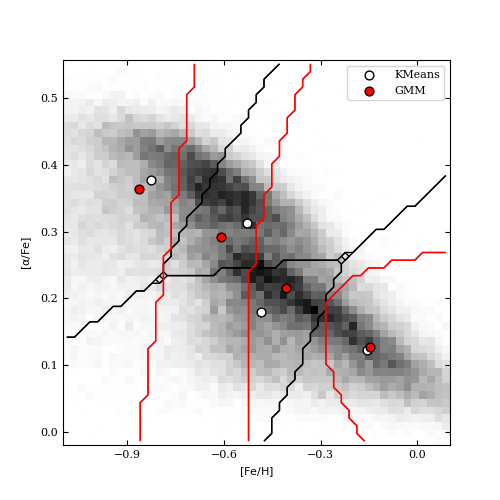

In [1]:
%matplotlib notebook
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 4

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
#  Compute GMM clustering - R.Sautter
gmm = mixture.GaussianMixture(n_components=4,  covariance_type='full',max_iter=3000).fit(X)



#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k',  label="KMeans")

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = gmm.predict(Xgrid).reshape((50, 50))
for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    ax.contour(FeH_centers, alphFe_centers, Hcp, [0.5], linewidths=1, colors='r')
    
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
           s=40, c='red', edgecolors='k', label="GMM")
plt.legend()
plt.show()

### 1.2 Visualizing

To understand what have been learned, let's see the raw data

In [9]:
import pandas as pd
pdData = pd.DataFrame(data)
pd.DataFrame(pdData["alphFe"]).head()

,alphFe
0,0.28739
1,0.24915
2,0.39253
3,0.24411
4,0.23225


<IPython.core.display.Javascript object>


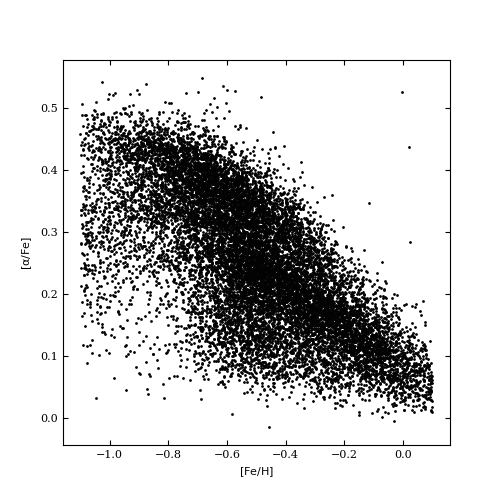

In [153]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1],
           s=1, c='w', edgecolors='k')
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'$\rm [\alpha/Fe]$')
plt.show()

### 1.3 Preprocessing

Althought the downloaded data has been cleaned, the preprocessing is still required. As shown at the histogram, there is two major stellar populations. However, we cannot see clearly those populations at the scatterplot. Therefore, a subset was selected to train the model. 

<IPython.core.display.Javascript object>


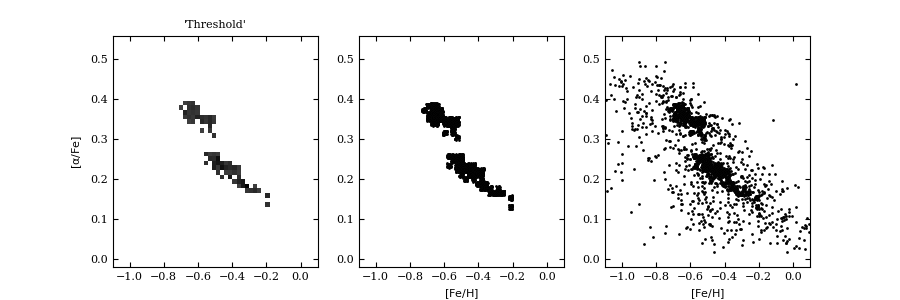

In [86]:
import pandas as pd
###############################################################################################
# Plotting 2
#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
#  Normalizing histogram
normH = H/np.max(H)
plt.figure(figsize=(9, 3))
plt.subplot(1,3,1)
# eroding the histogram
normH[np.where(normH<0.75)] = 0.0
plt.imshow(normH.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
plt.title("\'Threshold\'")
X2 = list(zip(np.where(normH>0.0)[0], np.where(normH>0.0)[1]))
plt.ylabel(r'$\rm [\alpha/Fe]$')
# Converting scale
X2 = np.array([[FeH_bins[temp[0]],alphFe_bins[temp[1]]] for temp in X2])
# X3 is the preprocessed list
dy, dx = abs(alphFe_bins[1]-alphFe_bins[0])/2, abs(FeH_bins[1]-FeH_bins[0])/2
Xthreshold = []
for pixel in X2:
    for point in X:
        if(abs(point[0]-pixel[0])<dx):
            if(abs(point[1]-pixel[1])<dy):
                Xthreshold.append(point)
Xthreshold = np.array(Xthreshold)
plt.subplot(1,3,2)
plt.scatter(Xthreshold[:, 0], Xthreshold[:, 1],
           s=1, c='w', edgecolors='k')
plt.xlim(min(FeH_bins),max(FeH_bins))
plt.ylim(min(alphFe_bins),max(alphFe_bins))
plt.xlabel(r'$\rm [Fe/H]$')

plt.subplot(1,3,3)

Xdf = pd.DataFrame(X)
XTdf = pd.DataFrame(Xthreshold)
sampleT = XTdf.sample(int(0.5*len(XTdf)))
sample = Xdf.sample(int(0.4*len(XTdf))).append(sampleT).drop_duplicates()
Xsampled = XTdf.values

plt.scatter(sample.values[:, 0], sample.values[:, 1],
           s=1, c='w', edgecolors='k')
plt.xlim(min(FeH_bins),max(FeH_bins))
plt.ylim(min(alphFe_bins),max(alphFe_bins))
plt.xlabel(r'$\rm [Fe/H]$')


plt.show()

<IPython.core.display.Javascript object>


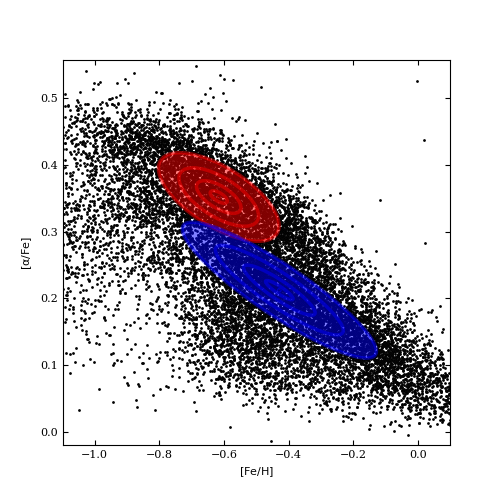

<IPython.core.display.Javascript object>


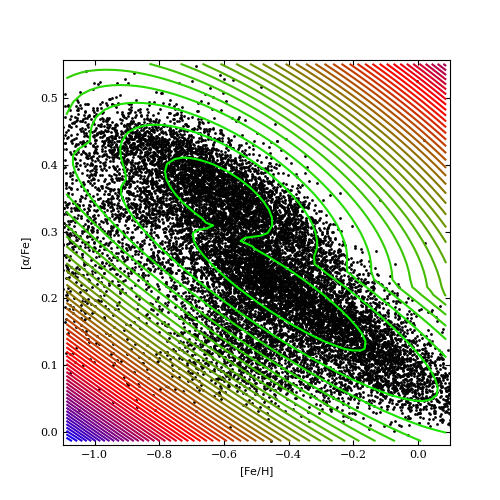

In [87]:
import matplotlib as mpl


colors = ['red','blue']

# Original src: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
# Modified: RAS, 2019
def make_ellipses(gmm, ax):
    nell = 5 
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        for it, i in enumerate(np.linspace(0.1, 3.5,nell)):
            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = i * np.sqrt(i) * np.sqrt(v)
            if it == nell-1:
                ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, alpha=0.05,lw=2.5,color=color)
                ell.set_alpha(0.5)
                ax.add_artist(ell)
            elif it == 0:
                ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, alpha=0.001,lw=2.5,color=color)
                ell.set_alpha(0.5)
                ax.add_artist(ell)
            else:
                ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, fill=None,lw=2.5,color=color)
                ell.set_alpha(0.5)
                ax.add_artist(ell)
            #ax.set_aspect('equal', 'datalim')


gmm = mixture.GaussianMixture(n_components=2, covariance_type='full',tol= 1e-5,max_iter=5000).fit(Xsampled)
H = gmm.score_samples(Xgrid)
H = pd.DataFrame(H)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax = plt.axes()


plt.scatter(X[:, 0], X[:, 1],
           s=1, c='w', edgecolors='k')
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'$\rm [\alpha/Fe]$')

make_ellipses(gmm,ax)
plt.xlim(min(FeH_bins),max(FeH_bins))
plt.ylim(min(alphFe_bins),max(alphFe_bins))
plt.show()

plt.figure(figsize=(5, 5))

plt.scatter(X[:, 0], X[:, 1],
           s=1, c='w', edgecolors='k')
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'$\rm [\alpha/Fe]$')

plt.contour(np.array(H).reshape(50,50), origin='lower',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]], levels= 50, cmap='brg')
plt.xlim(min(FeH_bins),max(FeH_bins))
plt.ylim(min(alphFe_bins),max(alphFe_bins))
plt.show()

### Notes

"Although the \[$\alpha$/Fe\] ratio is determined by the SSPP, the estimate is not available in the DR8. A detailed description of the alpha measurement can be found in Lee et al. (2011). Note that the \[$\alpha$/Fe\] ratio was released in DR7. However, it is not recommend to use it as its measurement and error were not well characterized as decribed in Lee et al. (2011)." [(SDSS,2013)](http://www.sdss3.org/dr8/spectro/sspp.php)

APOGEE Stellar Parameter and Chemical Abundance Pipeline ([ASPCAP](https://www.sdss.org/dr13/irspec/aspcap/)) is the most recent Sloan chemical survey.  

## 2. Great Wall

Althought the universe is homogeneous and isotropic in large scales, one can observe structures in smaller scales. The great wall is a cosmological structure discovered by [Gott, J. Richard, III; et al. (2005)](https://arxiv.org/abs/astro-ph/0310571). The structure is a filament composed by galaxies, which extends 1.4 billion light years. Analysing this structure is important to verify if N-Body simulations are indeed consistent.

One approach to compare is using image metrics. To extract metrics, we need to convert our scatter points in images. The following code shows three kernel methods: Gaussian, Exponential and  TopHat. 

$$ f(x) = {1\over nh^d}\sum\limits_{i}^{n} K \left({||x-x_i|| \over h} \right)$$

<figure>
	<img src="fig/kernels.png">
</figure>
<center>Source: <a href = "https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html">Scikit</a></center>




/home/rubens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


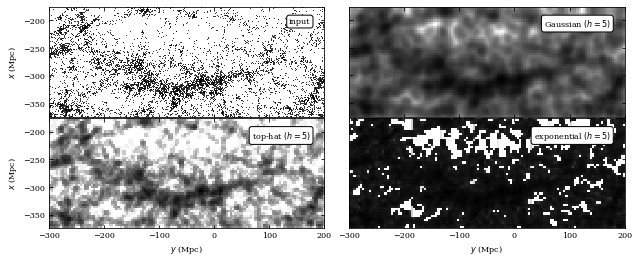

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kernels = ['gaussian', 'tophat', 'exponential']
dens = []

kde1 = KernelDensity(bandwidth=5, kernel='gaussian')
log_dens1 = kde1.fit(X).score_samples(Xgrid)
dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

kde2 = KernelDensity(bandwidth=5, kernel='tophat')
log_dens2 = kde2.fit(X).score_samples(Xgrid)
dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='exponential')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

kde3 = KernelDensity(bandwidth=5, kernel='epanechnikov')
log_dens3 = kde3.fit(X).score_samples(Xgrid)
dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4.4))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

### Acessing raw data

In [22]:
import os
import pandas as pd

import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astroML.datasets.sdss_specgals as specgals


cosmo = FlatLambdaCDM(H0=73.2, Om0=0.27, Tcmb0=0)
#                                    astroML home                download_if_missing
data = specgals.fetch_sdss_specgals('/home/rubens/astroML_data', True)

In [28]:
# Partially copied from VanderPlas(2008)
data = data[(data['dec'] > -7) & (data['dec'] < 7)]
data = data[(data['ra'] > 80) & (data['ra'] < 280)]

# do a redshift cut, following Cowan et al 2008
z = data['z']
data = data[(z > 0.01) & (z < 0.12)]
z = data['z']
ra = data['ra']
dec = data['dec']

59316


<IPython.core.display.Javascript object>


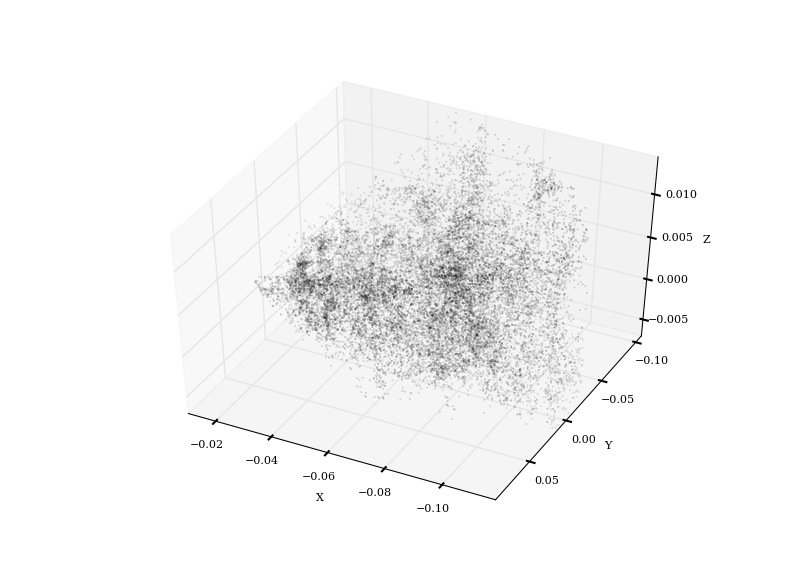

In [75]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import pandas as pd

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree,distance=z, frame='icrs')

cartesian = pd.DataFrame()
cartesian["x"] =c.cartesian.x 
cartesian["y"] =c.cartesian.y 
cartesian["z"] =c.cartesian.z 

plotData = cartesian.sample(20000)
print(len(cartesian))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plotData.x , plotData.y , plotData.z , marker='.',s=0.05, color='k')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

### GPA

The Gradient Pattern Analysis (GPA) is technique that characterizes lattices by means of its gradient asymmetries.

<figure>
	<img src="fig/gpa1.png">
</figure>
<center>Source: <a href = "https://arxiv.org/pdf/1803.10853.pdf">Rosa, R.R.; et. al(2018)</a></center>

<figure>
	<img src="fig/gpa2.png">
</figure>

In GPA formalism, there is four Gradient Moments: GP1, GP2, GP3 and GP4. Every gradient moment is a representation of the gradient field. For instance, GP1  contains the full-vector field lattice, GP2 contains gradient modulus lattice and GP3 contains gradient phase lattice. At every gradient moment, one can extract some parameter to characterize the observed pattern. The following parameters were applied in this problem:    

$$G_1 = {N_C - N_V \over N_V}$$

$$G_2 = {V_A \over V}\left( 2 - {\left|\sum\limits^{V_A}_{i} v_i\right| \over \sum\limits^{V_A}_{i}\left| v_i\right|}\right)$$

The following code show how to run [GPA](https://github.com/rsautter/GPA/tree/master/gpa).

In [3]:
from  gpa import GPA as ga

tol, rad_tol = 0.03, 0.03
gaObject = ga.GPA(tol,rad_tol)
g2, g1 = gaObject.evaluate(dens3,moment = ["G1","G2"])
g2, g1

(0.2871999510459286, 1.981)

In [ ]:
from  gpa import GPA as ga

tol, rad_tol = 0.03, 0.03

g1List = [[],[],[]]
g2List = [[],[],[]]
bands = []

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

for band in np.linspace(3.0,6.0, 20):
    
    kde1 = KernelDensity(bandwidth=band, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))
    gaObject = ga.GPA(tol,rad_tol)
    g2, g1 = gaObject.evaluate(dens1, moment = ["G2","G1"])
    print(g2,g1)
    g1List[0].append(g1)
    g2List[0].append(g2)
    
    kde2 = KernelDensity(bandwidth=band, kernel='tophat')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))
    gaObject = ga.GPA(tol,rad_tol)
    g2, g1 = gaObject.evaluate(dens2, moment = ["G2","G1"])
    g1List[1].append(g1)
    g2List[1].append(g2)
    
    kde3 = KernelDensity(bandwidth=band, kernel='exponential')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
    gaObject = ga.GPA(tol,rad_tol)
    g2, g1 = gaObject.evaluate(dens3, moment = ["G2","G1"])
    g1List[2].append(g1)
    g2List[2].append(g2)
    
    bands.append(band)
    

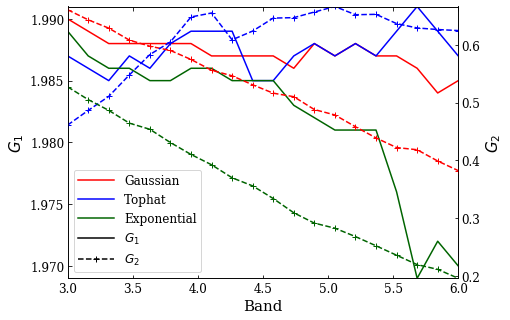

In [24]:
from matplotlib.lines import Line2D
import matplotlib as mpl

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(7,5))
plt.plot(bands,g1List[0],color='r',label='Gaussian')
plt.plot(bands,g1List[1],color='b',label='Tophat')
plt.plot(bands,g1List[2],color='darkgreen',label='Exponential')
plt.ylabel(r"$G_1$",fontsize=15)
plt.xlabel("Band",fontsize=15)

plt.twinx()
plt.plot(bands,g2List[0],color='r',ls='--',marker='+',label='Gaussian')
plt.plot(bands,g2List[1],color='b',ls='--',marker='+',label='Tophat')
plt.plot(bands,g2List[2],color='darkgreen',ls='--',marker='+',label='Exponential')
plt.xlabel("Band",fontsize=15)
plt.ylabel(r"$G_2$",fontsize=15)

art = [
    Line2D([0],[0],color='r'),
    Line2D([0],[0],color='b'),
    Line2D([0],[0],color='darkgreen'),
    Line2D([0],[0],color='k'),
    Line2D([0],[0],color='k',ls ='--', marker='+')
]
plt.legend(art,['Gaussian','Tophat','Exponential',r'$G_1$',r'$G_2$'],fontsize=12)

plt.show()

### Hierarchical Clustering


 scale: 3.54953 Mpc


/home/rubens/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


<IPython.core.display.Javascript object>


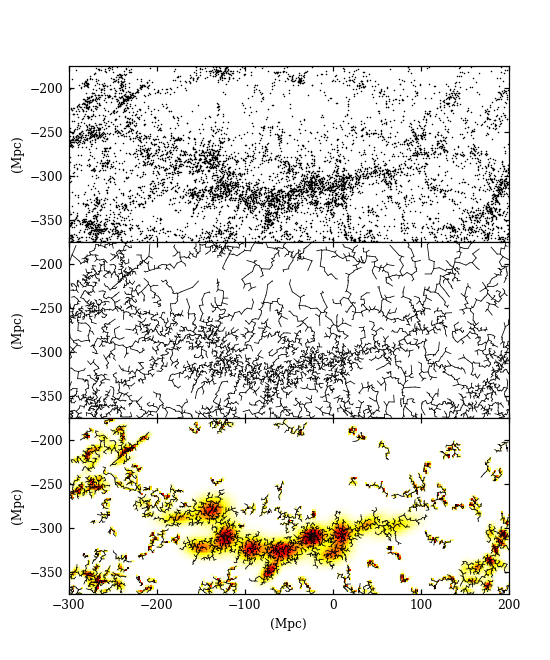

In [3]:

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

from scipy import sparse
from sklearn.mixture import GaussianMixture

from astroML.clustering import HierarchicalClustering, get_graph_segments
from astroML.datasets import fetch_great_wall

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# get data
X = fetch_great_wall()

xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Compute the MST clustering model
n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=10,
                               edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(X)
print(" scale: %2g Mpc" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))

n_components = model.n_components_
labels = model.labels_

#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

#------------------------------------------------------------
# Fit a GaussianMixture to each individual cluster
Nx = 100
Ny = 250
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T
density = np.zeros(Xgrid.shape[0])

for i in range(n_components):
    ind = (labels == i)
    Npts = ind.sum()
    Nclusters = min(12, Npts // 5)
    gmm = GaussianMixture(Nclusters, random_state=0).fit(X[ind])
    dens = np.exp(gmm.score_samples(Xgrid))
    density += dens / dens.max()
    

density = density.reshape((Ny, Nx))

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 6))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(312, aspect='equal')
ax.plot(T_y, T_x, c='k', lw=0.5)
ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('(Mpc)')

ax = fig.add_subplot(313, aspect='equal')
ax.plot(T_trunc_y, T_trunc_x, c='k', lw=0.5)
ax.imshow(density.T, origin='lower', cmap=plt.cm.hot_r,
          extent=[ymin, ymax, xmin, xmax])

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('(Mpc)')
ax.set_ylabel('(Mpc)')

plt.show()

## 3. Binomial Analysis
-------
Binomial distribution analysis is fundamental to all areas of knowledge, as these techniques are the basis for most of optimization problems, statistics, and machine learning. The binomial analysis determines the degree of dissimilarity in a given set of distributions.

There are many binomial distribution distances, such as: [Kullback-Leibler divergence](https://projecteuclid.org/euclid.aos/1176350606), [Hellinger distance](https://eudml.org/doc/149313) and [Bhattacharyya distance](https://pdfs.semanticscholar.org/768f/743d6697332e909587234b8643839fdd326e.pdf). In the following sections we present Hellinger distance, the Kullback-Leibler divergence, and the Geometric Histogram of Separation (GHS).

<figure>
	<img src="fig/decision.png">
</figure>



### 3.1 Hellinger distance

This distance have been used as split criterion for Decision Trees [(Cieslak, et al. 2011)](https://www3.nd.edu/~nchawla/papers/DMKD11.pdf).

\begin{equation}
    D_H(P,Q) = \sum{\left|\left|\sqrt{P}-\sqrt{Q}\right|\right| \over \sqrt{2}}
\end{equation}


### 3.2 Kullback-Leibler divergence

\begin{equation}
    D_{KL}(P|Q) = \sum P \,log \left({P \over Q}\right)
\end{equation}

\begin{equation}
    D_{KL}(P,Q) = \sum (P-Q)\, log \left({P \over Q}\right)
\end{equation}

In [9]:
# %load GHS/distanceMetrics.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import pandas as pd
import sys


#python version :
#source:
def hellinger1(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2)) /  np.sqrt(2)

def hellinger(a,b):
    p, _ = np.histogram(a)
    q, _ = np.histogram(b)
    p, q = p/np.sum(p), q/np.sum(q)
    return hellinger1(p,q)

def kl(d1, d2):
    dd1,dd2 = d1/sum(d1),d2/sum(d2)
    where = (d1>0.0001) & (d2>0.0001) 
    if not (True in where):
        return np.inf
    return sum(dd1[where]*np.log(dd1[where]/dd2[where]))

def dkl1(d1, d2):
    dd1,dd2 = d1/sum(d1),d2/sum(d2)
    where = (d1>0.0001) & (d2>0.0001) 
    if not (True in where):
        return np.inf
    return sum((dd1[where]-dd2[where])*np.log(dd1[where]/dd2[where]))

def dkl(a,b):
    p, _ = np.histogram(a)
    q, _ = np.histogram(b)
    p, q = p/np.sum(p), q/np.sum(q)
    return dkl1(p,q)

### 3.3 GHS module 
GHS was proposed to rate galaxy morphological metrics [(Rosa, et al. 2018)](https://arxiv.org/abs/1803.10853). This metric have been especially effective to describe problems with skewed distributions. It is inspired by the box-counting algorithm [(Mandelbrot,1983)](https://aapt.scitation.org/doi/10.1119/1.13295). 

Consider the distribution R and B, as shown in figure bellow. In this example, there is a region for the distribution R, B, and the intersection between R and B. Considering the histogram regions, we measure the normalized intersection area ($\delta_{BCA}$) and the distance between distribution peaks ($\delta_{BCL}$). 

<img src="fig/img69.jpg" alt="Drawing" style="width: 400px;"/>

Where, $\delta_{BCA}$ and $\delta_{BCL}$ are measured according to: 



\begin{equation}
\delta_{BCA} = 1 - { A_{RB} \over A_B + A_R + A_{RB}}
\end{equation}

\begin{equation}
\delta_{BCL} = {h_a + h_b - 2 h_c \over h_a + h_b}
\end{equation}

Finally, GHS is measured as:

\begin{equation}
\delta_{GHS} = {\sqrt{\delta_{BCA}}+\delta_{BCL} \over 2}
\end{equation}

--------
For didatic prupose, lets consider some examples:

<img src="fig/exemplo.png" alt="Drawing" style="width: 700px;"/>

    1 - When the distributions are equal (R = B),
\begin{equation}
\delta_{BCA} = 1 - { A_{RB} \over A_B + A_R + A_{BR}} = 1 - { 1 \over 0 + 0 + 1} = 0  
\end{equation}

\begin{equation}
\delta_{BCL} = {h_a + h_b - 2 h_c \over h_a + h_b} = {h + h - 2 h \over h + h} = 0
\end{equation}
    
        Thus,
\begin{equation}
\delta_{GHS} = {\sqrt{\delta_{BCA}}+\delta_{BCL} \over 2} = 0
\end{equation}

    2 - When there is no overlapping between the distributions,
    
\begin{equation}
\delta_{BCA} = 1 - { A_{RB} \over A_B + A_R + A_{BR}} = 1 - { 0 \over 1 + 1 + 0} = 1  
\end{equation}   

\begin{equation}
\delta_{BCL} = {h_a + h_b - 2 h_c \over h_a + h_b} = {h_a + h_b \over h_a + h_b} = 1
\end{equation}

        Thus,
    
\begin{equation}
\delta_{GHS} = {\sqrt{1}+1 \over 2} = 1
\end{equation}

----

The source code is available [here](https://github.com/rsautter/GHS). 
Note that the metric calculation is independent of the convergence of the box-counting, instead we measure the real area.

In [14]:
# %load GHS/ghs2
import numpy
import pandas as pd
from math import sqrt
import sys

def wSum(bca,bcl,weightType):
    '''
    wSum - weigth sum
    ----------------------------------------------
    Input:
    bca - box counting area
    bcl  -box counting length
    weightType - type of weight (1, 2, 3)

    Output:
    GHS - the weigthed sum of bca and bcl
    ----------------------------------------------
    Type I - w1 = sqrt(bca)/bca
    Type II - w2 =  2 * w1
    Type III - w2 = bcl
    '''
    output = 0.0
    alpha,beta = 1.0,1.0

    if(weightType == 1):
        alpha, beta = sqrt(bca)/bca, 1
    elif(weightType == 2):
        alpha, beta = 1.0, 2.0
    elif(weightType == 3):
        alpha, beta = 1.0, bcl
    else:
        print("\nWarning,invalid weight code, using default weights.\n    ")
    
    #error handling:
    if(alpha+beta<0):
        raise Exception("Invalid sum weights")    

    output = (alpha*bca+beta*bcl)/(alpha+beta)    
    #print("Weight:",alpha,beta)

    return output

def ghsFromHist(hist1, hist2, dx, onlyGHS=False):
    '''
    GHS - Geometric Histogram Separation
    ----------------------------------------------
    Input:
    data1,data2 - The data samples - list or numpy.ndarray
   onlyGHS - return only GHS, otherwise return BCA, BCL and GHS

    Output:
    BCA, BCL, GHS - The metrics - tuple of float64

    ----------------------------------------------
    This function measures the Box Counting Area (BCA) and
    the Box Counting Linear (BCL) between data1 and data2.
    The GHS is measured as average of BCA square root and BCL.
    '''
    dy = numpy.minimum(hist1,hist2)

    # ao is the relative area  
    ao = numpy.sum(dy*dx)

    a_height = numpy.max(hist1)
    b_height = numpy.max(hist2)
    c_height = numpy.max(dy)

    bcl = (a_height+b_height-2.0*c_height)/(a_height+b_height)
    bca = 1.0 - (ao) / (2.0 - ao)

    if(onlyGHS):
        return (bcl+sqrt(bca))/2.0
    return bca,bcl,(bcl+sqrt(bca))/2.0

def ghs(data1, data2,onlyGHS=False):
    '''
    GHS - Geometric Histogram Separation
    ----------------------------------------------
    Input:
    data1,data2 - The data samples - list or numpy.ndarray
   onlyGHS - return only GHS, otherwise return BCA, BCL and GHS

    Output:
    BCA, BCL, GHS - The metrics - tuple of float64

    ----------------------------------------------
    This function measures the Box Counting Area (BCA) and
    the Box Counting Linear (BCL) between data1 and data2.
    The GHS is measured as average of BCA square root and BCL.
    '''
    hist1, bins1 = numpy.histogram(data1)
    hist2, bins2 = numpy.histogram(data2)
    both = numpy.concatenate((bins1,bins2))
    # n is the number of bins (average between the number of both bins)
    n = int(len(both)/2)
    rnge = (numpy.min(both),numpy.max(both))
    hist1, bins1 = numpy.histogram(data1,bins=n,range=rnge)
    hist2, bins2 = numpy.histogram(data2,bins=n,range=rnge)
    hist1 = hist1/np.sum(hist1)
    hist2 = hist2/np.sum(hist2)

    # since both histograms have same bins, dy is the intersection:
    dx = (rnge[1]-rnge[0])/n
    dy = numpy.minimum(hist1,hist2)

    # ao is the relative area  
    ao = numpy.sum(dy*dx)

    a_height = numpy.max(hist1)
    b_height = numpy.max(hist2)
    c_height = numpy.max(dy)

    bcl = (a_height+b_height-2.0*c_height)/(a_height+b_height)
    bca = 1.0 - (ao) / (2.0 - ao)

    if(onlyGHS):
        return (bcl+sqrt(bca))/2.0
    return bca,bcl,(bcl+sqrt(bca))/2.0

def ghs2(data1,data2,typeSum,onlyGHS=False):
    '''
    GHS - Geometric Histogram Separation
    ----------------------------------------------
    Input:
    data1,data2 - The data samples - list or numpy.ndarray
    typeSum - Type of sum (1, 2, or 3)
   onlyGHS - return only GHS, otherwise return BCA, BCL and GHS

    Output:
    BCA, BCL, GHS - The metrics - tuple of float64

    ----------------------------------------------
    This function measures the Box Counting Area (BCA) and
    the Box Counting Linear (BCL) between data1 and data2.
    The GHS is measured as average of BCA square root and BCL.
    '''
    hist1, bins1 = numpy.histogram(data1)
    hist2, bins2 = numpy.histogram(data2)
    both = numpy.concatenate((bins1,bins2))
    # n is the number of bins (average between the number of both bins)
    n = int(len(both)/2)
    rnge = (numpy.min(both),numpy.max(both))
    hist1, bins1 = numpy.histogram(data1,bins=n,range=rnge)
    hist2, bins2 = numpy.histogram(data2,bins=n,range=rnge)
    hist1 = hist1/np.sum(hist1)
    hist2 = hist2/np.sum(hist2)

    # since both histograms have same bins, dy is the intersection:
    dx = (rnge[1]-rnge[0])/n
    dy = numpy.minimum(hist1,hist2)

    # ao is the relative area  
    ao = numpy.sum(dy*dx)

    a_height = numpy.max(hist1)
    b_height = numpy.max(hist2)
    c_height = numpy.max(dy)

    bcl = (a_height+b_height-2.0*c_height)/(a_height+b_height)
    bca = 1.0 - (ao) / (2.0 - ao)
    try:
        ghs = wSum(bca,bcl,typeSum)
    except:
        raise
    if(onlyGHS):
        return ghs
    return bca,bcl,ghs

<IPython.core.display.Javascript object>


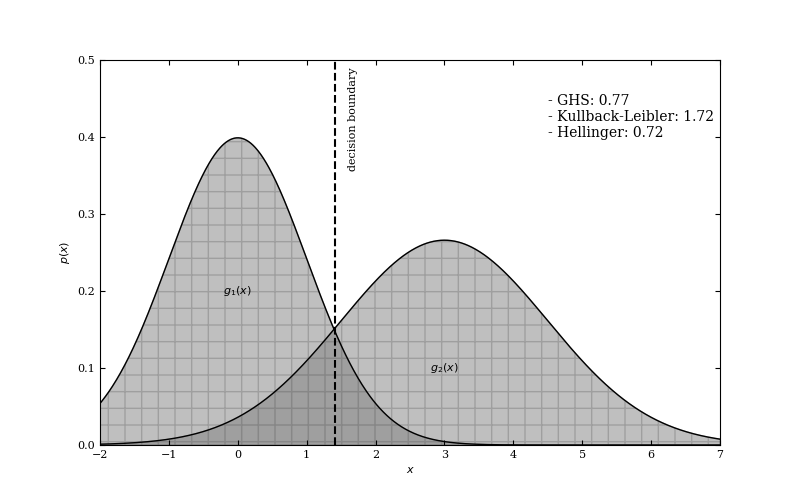

In [15]:
%matplotlib notebook
# Author: Jake VanderPlas
# Adapted by: Rubens A. Sautter
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from matplotlib.patches import Rectangle

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Compute the two PDFs
x = np.linspace(-3, 7, 1000)
pdf1 = norm(0, 1).pdf(x)
pdf2 = norm(3, 1.5).pdf(x)
x_bound = x[np.where(pdf1 < pdf2)][0]

#------------------------------------------------------------
# Measure the separation metrics
pdfsGHS = ghsFromHist(pdf1/sum(pdf1),pdf2/sum(pdf2), x[1]-x[0]) 
pdfsKL = dkl1(pdf1/sum(pdf1),pdf2/sum(pdf2))
pdfsHell = hellinger1(pdf1/sum(pdf1),pdf2/sum(pdf2))


table = "- GHS: "+str(round(pdfsGHS[2],2))+"\n"
table += "- Kullback-Leibler: "+str(round(pdfsKL,2))+"\n"
table += "- Hellinger: "+str(round(pdfsHell,2))

#------------------------------------------------------------
# Plot the pdfs and decision boundary

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(x, pdf1, '-k', lw=1)
ax.fill_between(x, pdf1, color='gray', hatch='+',alpha=0.5)

ax.plot(x, pdf2, '-k', lw=1)
ax.fill_between(x, pdf2, color='gray',hatch='+', alpha=0.5)

# plot decision boundary
ax.plot([x_bound, x_bound], [0, 0.5], '--k')

ax.text(x_bound + 0.2, 0.49, "decision boundary",
        ha='left', va='top', rotation=90)

ax.text(0, 0.2, '$g_1(x)$', ha='center', va='center')
        
ax.text(3, 0.1, '$g_2(x)$', ha='center', va='center')

ax.set_xlim(-2, 7)
ax.set_ylim(0, 0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# manually placing a text with histogram metrics 
plt.text(4.5,0.40,table,size=10)
# manually add an rectangle
w,h = 0.26, 0.023
#ax.add_artist(Rectangle(xy=(4.54, 0.36),color='gray',width=w, height=h))
#plt.text(4.9,0.365,"- Area: "+str(round(w*h,2)),size=10)

plt.show()

### Gerando os exemplos 'didáticos'


<IPython.core.display.Javascript object>


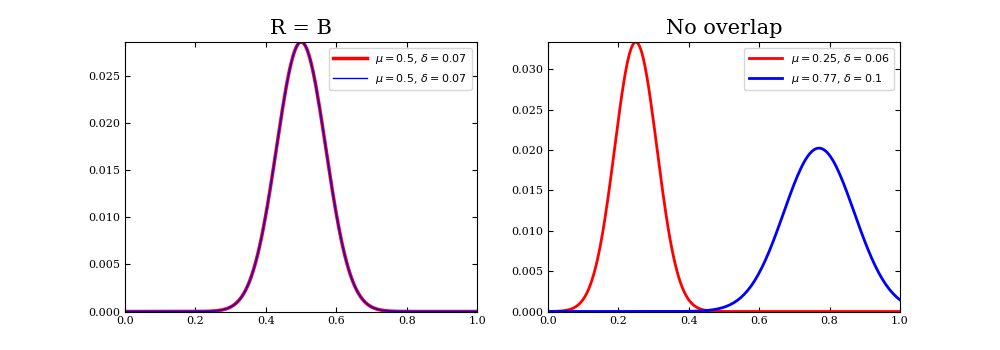

In [45]:
x = np.linspace(0, 1, 200)
pdf1 = norm(0.25, 0.06).pdf(x)
pdf2 = norm(0.77, 0.1).pdf(x)
fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(122)
ax.plot(x, pdf1/sum(pdf1), '-r', lw=2,label=r"$\mu = 0.25$, $\delta=0.06$")
ax.plot(x, pdf2/sum(pdf2), '-b', lw=2,label=r"$\mu = 0.77$, $\delta=0.1$")
plt.title("No overlap",size= 15)
plt.legend()

pdf1 = norm(0.5, 0.07).pdf(x)
pdf2 = norm(0.5, 0.07).pdf(x)
ax = fig.add_subplot(121)
ax.plot(x, pdf1/sum(pdf1), '-r', lw=2.5,label=r"$\mu = 0.5$, $\delta=0.07$")
#ax.fill_between(x, pdf1/sum(pdf1), color='r',hatch='+', alpha=0.5)
ax.plot(x, pdf2/sum(pdf2), '-b', lw=1,label=r"$\mu = 0.5$, $\delta=0.07$")
#ax.fill_between(x, pdf2/sum(pdf2), color='b',hatch='+', alpha=0.5)
plt.title("R = B",size= 15)
plt.legend()


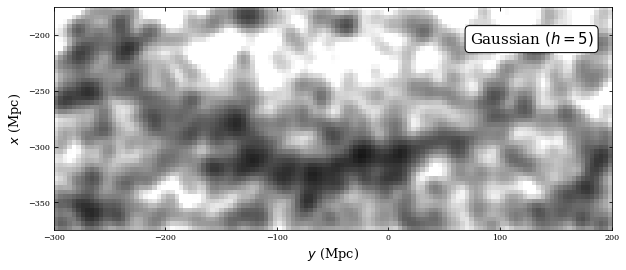

In [20]:
plt.figure(figsize=(10, 4.4))
ax = plt.subplot(111)
ax.imshow(dens1.T, origin='lower', norm=LogNorm(),extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax.images[0].set_clim(0.01, 0.8)
ax.set_xlim(ymin, ymax - 0.01)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('$y$ (Mpc)',fontsize=13)
ax.set_ylabel('$x$ (Mpc)',fontsize=13)
ax.text(1.8, 1.6, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'),fontsize=15)
plt.show()

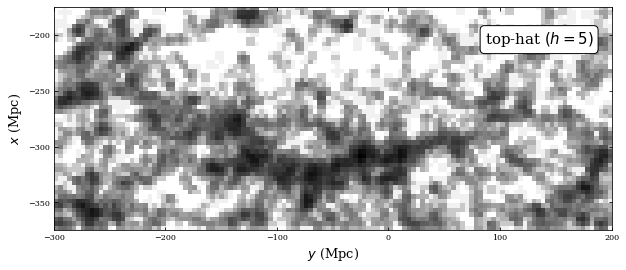

In [22]:
plt.figure(figsize=(10, 4.4))
ax = plt.subplot(111)
ax.imshow(dens2.T, origin='lower', norm=LogNorm(),extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax.images[0].set_clim(0.01, 0.8)
ax.set_xlim(ymin, ymax - 0.01)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('$y$ (Mpc)',fontsize=13)
ax.set_ylabel('$x$ (Mpc)',fontsize=13)
ax.text(1.8, 1.6, "top-hat $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'),fontsize=15)
plt.show()

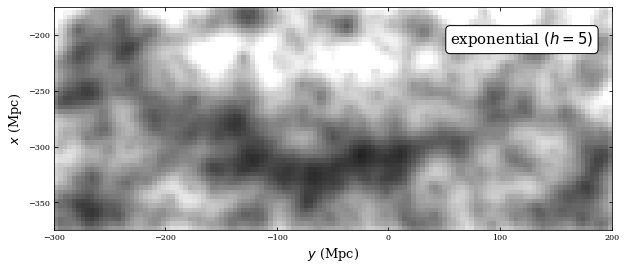

In [23]:
plt.figure(figsize=(10, 4.4))
ax = plt.subplot(111)
ax.imshow(dens3.T, origin='lower', norm=LogNorm(),extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax.images[0].set_clim(0.01, 0.8)
ax.set_xlim(ymin, ymax - 0.01)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('$y$ (Mpc)',fontsize=13)
ax.set_ylabel('$x$ (Mpc)',fontsize=13)
ax.text(1.8, 1.6, "exponential $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'),fontsize=15)
plt.show()

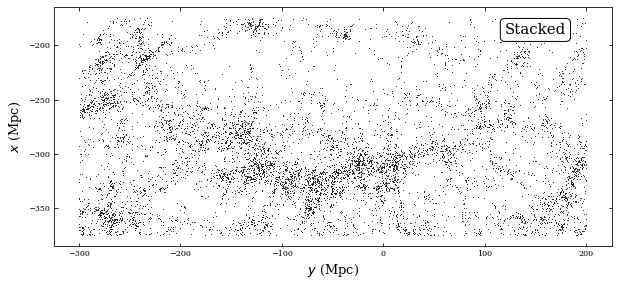

In [30]:
plt.figure(figsize=(10, 4.4))
ax = plt.subplot(111)
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax.text(1.7, 0.8, "Stacked", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'),fontsize=15)
ax.set_xlabel('$y$ (Mpc)',fontsize=13)
ax.set_ylabel('$x$ (Mpc)',fontsize=13)
plt.show()